# Gradient descent and Newton's method

(This exercise originates from S. Boyd's course Convex Optimization)

Consider the unconstrained problem
  
  $$\begin{array}{ll}minimize\,\,\, f(x) = - \sum_{i=1}^m \log(1-a_i^T x)- \sum_{i=1}^n \log(1 - x_i^2),\end{array}$$
  
  with variable $x \in \mathbf{R}^n$, and $\mathbf{dom} f = \{x \;|\; a_i^Tx \le 1, ~i=1, \ldots, m, ~|x_i| \le 1, ~i=1, \ldots, n\}$. This is the problem of computing the analytic center of the set of linear inequalities
  
  $$a_i^Tx \leq 1, \quad i=1, \ldots, m, \qquad |x_i|\leq 1,\quad i=1, \ldots, n.$$
 
 Note that we can choose $x^{(0)}=0$ as our initial point. You can generate instances of this problem by choosing $a_i$ from some distribution on $\mathbf{R}^n$.
 

1. Use the gradient descent method to solve the problem. Use backtracking line search (BLS) to choose the step size and a stopping criterion of the form $\| \nabla f(x)\|_2^2 \leq \delta$. You need to choose the parameters $\alpha,\beta$ of BLS as well as $\delta$ in a reasonable way. Plot the objective function and step length versus iteration number. (Once you have determined $p^\star$ to high accuracy, you can also plot $f-p^\star$ versus iteration.) Experiment with the backtracking parameters $\alpha$ and $\beta$ to see their effect on the total number of iterations required. 
2. Repeat using Newton&#39;s method, again with BLS and this time with a stopping criterion based on the square $\lambda^2$ of Newton decrement. Produce the plots as for GD. Can you see the sharp distinction between the areas of slow and fast convergence for the Newton&#39;s method?

Some notes and tips:
* You can find the description of BLS in the slides for the Newton's method lecture. The exact same formulation can be used for GD.
* The domain of the objective is not $\mathbf{R}^n$. So, your BLS needs make sure that the chosen step length results in a point inside the domain (on top of satisfying the standard BLS condition). 
* You are going to have to find formulas for $\nabla f(x)$ and $\nabla^2 f(x)$ by hand using chain rule. If you really want to, you can use pytorch (or other similar tools) for this task, but it is probably not worth it. The GD code and the Newton code has to be your own.
* In the Newton's algorithm do not invert the Hessian, use ``numpy.linalg.solve`` (or other linear system solver) instead.

## Solution
--------
##### For this problem we get the following equations:
- Gradient: $\nabla f(x) =  ∑_{i=1}^m (a_i / (1 - a_i^T x))  +  ∑_{i=1}^n (2x_i / (1 - x_i²))$
- Hessian: $\nabla^2 f(x) = ∑_{i=1}^m (a_i  a_i^T) / (1 - a_i^T x)^2  +  diag(2 / (1 - x_i^2)^2)$ , where $diag$ a $nxn$ matrix with values only in the diagonal.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
def objective_function_calculation(x, A):
    """
    Calculates f(x) parametrized by A matrix (which contains the m different a_i's) and current x value.
    """
    return -np.sum(np.log(1 - A @ x)) - np.sum(np.log(1 - x ** 2))


def gradient_calculation(x, A):
    """
    Calculates gradient of f(x) parametrized by A at point x.
    """
    return A.T @ (1 / (1 - A @ x)) + (2 * x) / (1 - x ** 2)


def hessian_calculation(x, A):
    """
    Computes the Hessian of f(x) parametrized by A at point x.
    """
    denominator = (1 - A @ x) ** 2
    outer_products = A[:, :, None] * A[:, None, :]
    diagonal_term = np.diag(2 / (1 - x ** 2) ** 2)
    return (outer_products / denominator[:, None, None]).sum(axis=0) + diagonal_term

--------
##### For the implementation of the backtracking line search, we need to check:
- If the new point ($x_{new}$) satisfies the constraint  $a_i^Tx_{new} \le 1$
- If also the new point satisfies the constraint $|x_i| \le 1$.
- And finally the primary condition of the BLS search, if $f(x_{new}) \le f(x) + a * t * \nabla f^T \Delta_{direction}$

In [43]:
def backtracking_line_search(x, A, direction, gradient, alpha, beta):
    """
    Calculates BLS given x, A, the gradient of the objective function at x, as well as parameters a and b.
    Checks 3 conditions:
    Check if the condition for ai^T * x < 1 holds.
    Check if the condition |x| < 1 holds.
    The main BLS check
    """
    t = 1
    while True:
        x_new = x + t * direction
        if np.all(A @ x_new <= 1) and \
                np.all(np.abs(x_new) <= 1) and \
                objective_function_calculation(x_new, A) <= \
                objective_function_calculation(x, A) + alpha * t * np.dot(gradient, direction):
            break
        t *= beta
    return t

--------
##### Here are the two methods below, as well as a helper function to call them.
As mentioned in the description, we dont explicitly find the inverse of the Hessian but rather we solve a system of linear equations:

$$\nabla^2 f(x) \Delta x = -\nabla f(x)$$
which translates to a $Ax=b$ problem with $A=\nabla^2 f(x)$, $x=\Delta x$, $b=-\nabla f(x)$

and for the decrements:

$$\lambda^2(x) = -\nabla f(x)^T\Delta x$$

In the code this translates to the following 2 lines:
```python
direction = np.linalg.solve(hessian, -gradient)
newton_lambda_square = -np.dot(gradient, direction)
```

In [44]:
def gradient_descent_bls(A, x, alpha, beta, stop_criterion, maximum_iterations):
    obj_values = [objective_function_calculation(x, A)]
    step_sizes = [1]
    iterations = 0

    while iterations < maximum_iterations:
        gradient = gradient_calculation(x, A)
        if np.linalg.norm(gradient, 2) ** 2 < stop_criterion:
            break

        direction = -gradient  # Descent direction is the negative gradient
        t = backtracking_line_search(x, A, direction, gradient, alpha, beta)
        x = x + t * direction

        obj_values.append(objective_function_calculation(x, A))
        step_sizes.append(t)
        iterations += 1

    # Calculate f(x^k) - p*, assuming that the last value is p*
    obj_values = [f - objective_function_calculation(x, A) for f in obj_values]

    return obj_values, step_sizes, iterations


def newton_method_bls(A, x, alpha, beta, stop_criterion, maximum_iterations):
    obj_values = [objective_function_calculation(x, A)]
    step_sizes = [1]
    newton_decrements = [np.inf]
    iterations = 0

    while iterations < maximum_iterations:
        gradient = gradient_calculation(x, A)
        hessian = hessian_calculation(x, A)

        direction = np.linalg.solve(hessian, -gradient)
        newton_lambda_square = -np.dot(gradient, direction)

        if newton_lambda_square <= stop_criterion:
            break

        t = backtracking_line_search(x, A, direction, gradient, alpha, beta)
        x = x + t * direction

        obj_values.append(objective_function_calculation(x, A))
        step_sizes.append(t)
        newton_decrements.append(np.sqrt(newton_lambda_square))
        iterations += 1
    # Calculate f(x^k) - p*, assuming that the last value is p*
    obj_values = [f - objective_function_calculation(x, A) for f in obj_values]

    return obj_values, step_sizes, iterations


def run_method(name, **kwargs):
    if name == 'Gradient Descent':
        return gradient_descent_bls(**kwargs)
    elif name == 'Newton Method':
        return newton_method_bls(**kwargs)
    else:
        raise ValueError("Choose Gradient Descend or Newton Method!")

--------
##### Experiments:
I tried nine combinations out of 3 values for alpha and beta. For $\delta$  and $\lambda^2$ I chose the value of $1e-6$ as a stopping criterion.
For the problem there was not any explicit guideline for the size, so I tried a $n=m=200$ sized problem. Other sizes work equally well.

In [45]:
np.random.seed(1995)

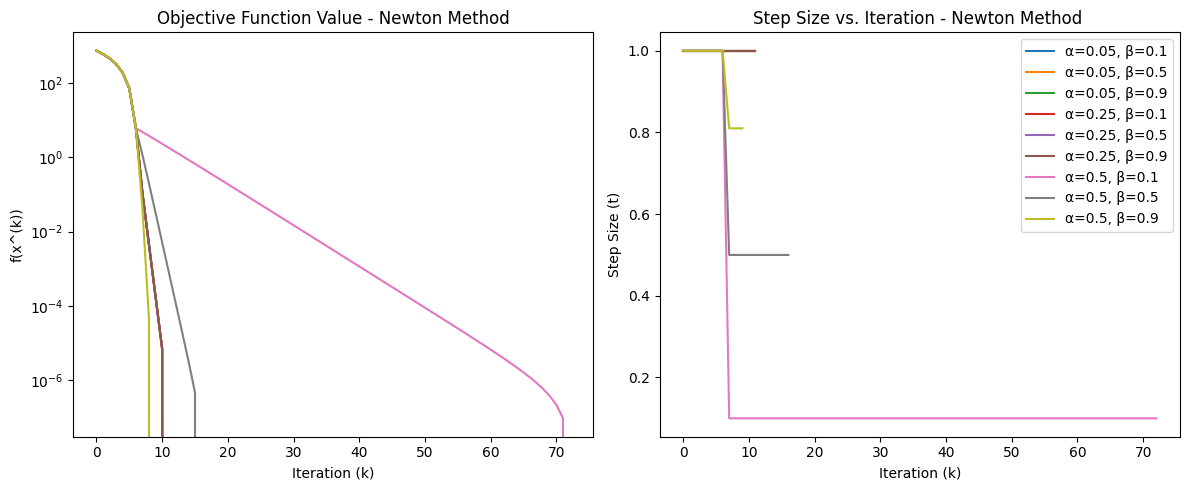

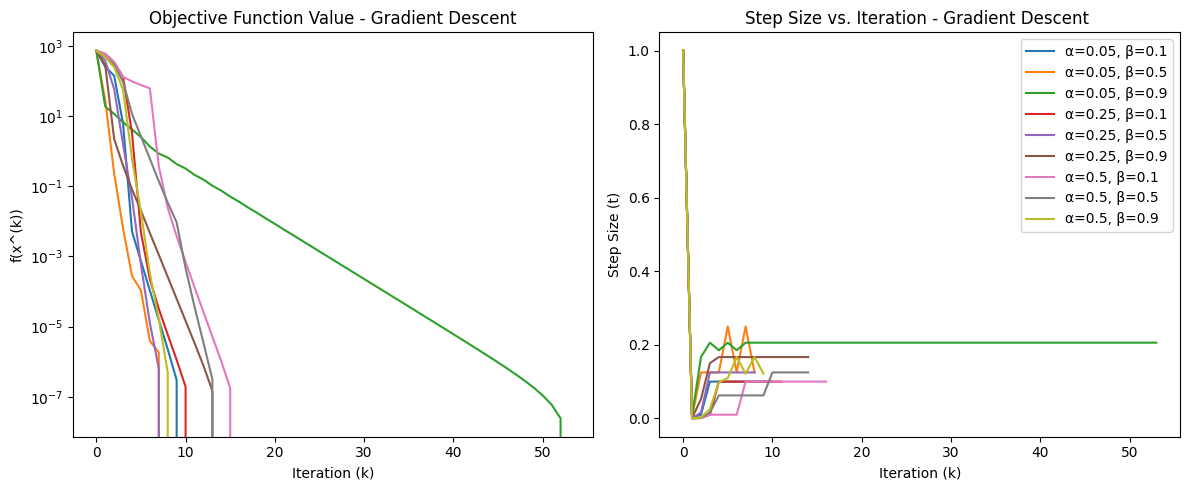

In [46]:
alpha_values = [0.05, 0.25, 0.5]
beta_values = [0.1, 0.5, 0.9]
stop_criterion = 1e-6
maximum_iterations = 2000
methods = ['Newton Method', 'Gradient Descent']

A = np.random.rand(200, 200)
x0 = np.zeros(200)
GD_stats = []
NT_stats = []
COMBINATIONS = []


for method_name in methods:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for alpha in alpha_values:
        for beta in beta_values:
            obj_values, step_sizes, iterations = run_method(name=method_name,
                                                              A=A,
                                                              x=x0,
                                                              alpha=alpha,
                                                              beta=beta,
                                                              stop_criterion=stop_criterion,
                                                              maximum_iterations=maximum_iterations
                                                              )

            # Plotting
            axes[0].semilogy(obj_values, label=f"α={alpha}, β={beta}")
            axes[1].plot(step_sizes, '-', markersize=2, label=f"α={alpha}, β={beta}")
            COMBINATIONS.append((alpha, beta))
            if method_name == 'Gradient Descent':
                GD_stats.append((obj_values,step_sizes, iterations))
            elif method_name == 'Newton Method':
                NT_stats.append((obj_values,step_sizes, iterations))


    axes[0].set_xlabel('Iteration (k)')
    axes[0].set_ylabel('f(x^(k))')
    axes[0].set_title(f'Objective Function Value - {method_name}')

    axes[1].set_xlabel('Iteration (k)')
    axes[1].set_ylabel('Step Size (t)')
    axes[1].set_title(f'Step Size vs. Iteration - {method_name} ')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

--------
#### Result Analysis

In [47]:
### Gather Gradient Descent stats ###
iterations = [f[-1] for f in GD_stats]
sorted_indices = np.argsort(iterations)
print("Top 3 combinations of alpha and beta for Gradient Descent:")
for i in sorted_indices[:3]:
    print(f"Alpha:{COMBINATIONS[i][0]} Beta:{COMBINATIONS[i][1]}")

Top 3 combinations of alpha and beta for Gradient Descent:
Alpha:0.05 Beta:0.5
Alpha:0.25 Beta:0.5
Alpha:0.5 Beta:0.9


In [48]:
### Gather Newton Method stats ###
iterations = [f[-1] for f in NT_stats]
sorted_indices = np.argsort(iterations)
print("Top 3 combinations of alpha and beta for Newton Method:")
for i in sorted_indices[:3]:
    print(f"Alpha:{COMBINATIONS[i][0]} Beta:{COMBINATIONS[i][1]}")

Top 3 combinations of alpha and beta for Newton Method:
Alpha:0.5 Beta:0.9
Alpha:0.05 Beta:0.1
Alpha:0.05 Beta:0.5


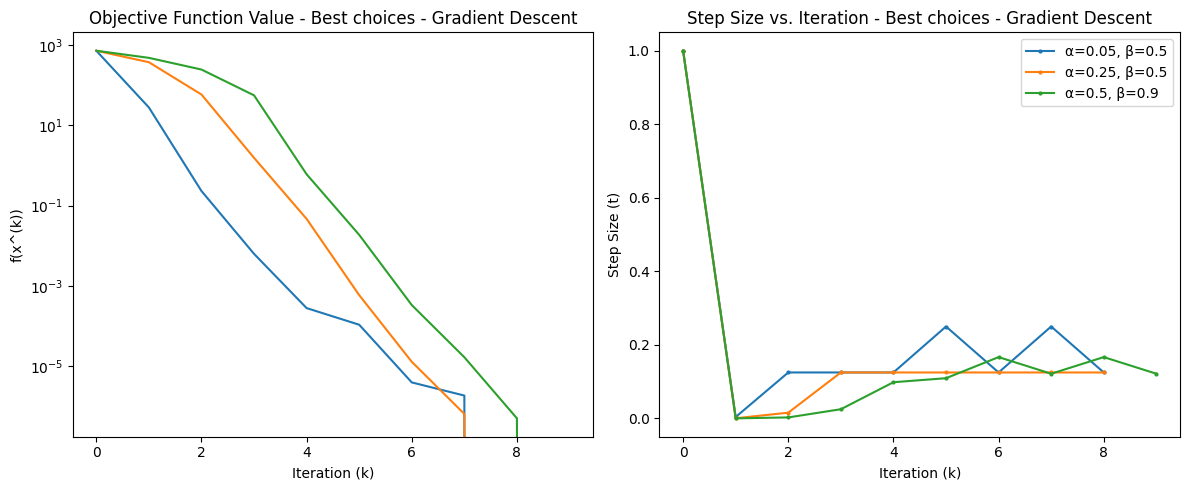

In [49]:
### Let's plot again the best runs for Gradient Descent###
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for alpha, beta in zip([0.05,0.25,0.5], [0.5,0.5,0.9]):
    obj_values, step_sizes, iterations = run_method(name='Gradient Descent',
                                                      A=A,
                                                      x=x0,
                                                      alpha=alpha,
                                                      beta=beta,
                                                      stop_criterion=stop_criterion,
                                                      maximum_iterations=maximum_iterations
                                                      )

    # Plotting
    axes[0].semilogy(obj_values, label=f"α={alpha}, β={beta}")
    axes[1].plot(step_sizes, 'o-', markersize=2, label=f"α={alpha}, β={beta}")


axes[0].set_xlabel('Iteration (k)')
axes[0].set_ylabel('f(x^(k))')
axes[0].set_title(f'Objective Function Value - Best choices - Gradient Descent')

axes[1].set_xlabel('Iteration (k)')
axes[1].set_ylabel('Step Size (t)')
axes[1].set_title(f'Step Size vs. Iteration - Best choices - Gradient Descent')
axes[1].legend()
plt.tight_layout()
plt.show()

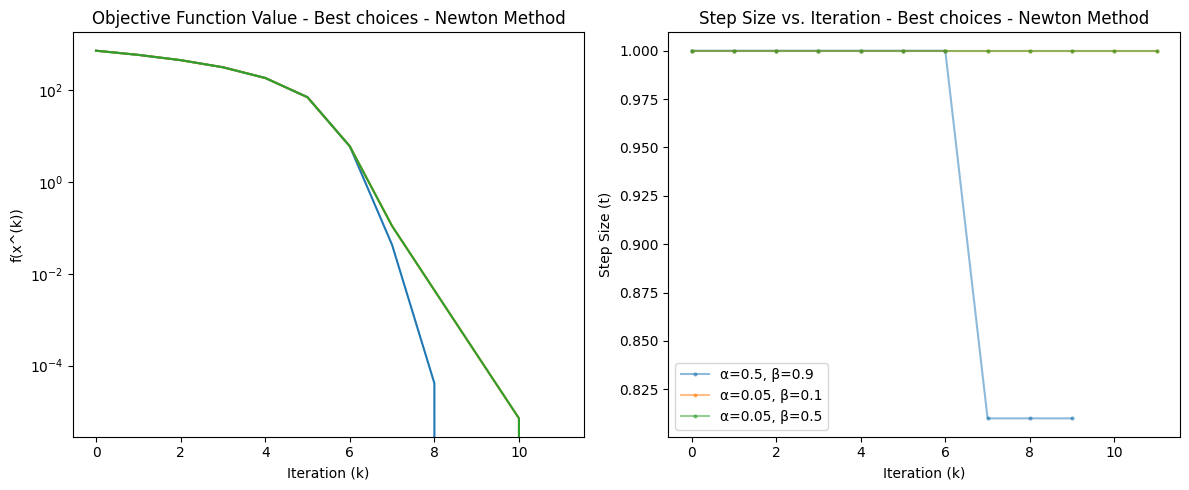

In [50]:
### Let's plot again the best runs for Newton Method###
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for alpha, beta in zip([0.5,0.05,0.05], [0.9,0.1,0.5]):
    obj_values, step_sizes, iterations = run_method(name='Newton Method',
                                                      A=A,
                                                      x=x0,
                                                      alpha=alpha,
                                                      beta=beta,
                                                      stop_criterion=stop_criterion,
                                                      maximum_iterations=maximum_iterations
                                                      )

    # Plotting
    axes[0].semilogy(obj_values, label=f"α={alpha}, β={beta}")
    axes[1].plot(step_sizes, 'o-', markersize=2, alpha=0.5, label=f"α={alpha}, β={beta}")


axes[0].set_xlabel('Iteration (k)')
axes[0].set_ylabel('f(x^(k))')
axes[0].set_title(f'Objective Function Value - Best choices - Newton Method')

axes[1].set_xlabel('Iteration (k)')
axes[1].set_ylabel('Step Size (t)')
axes[1].set_title(f'Step Size vs. Iteration - Best choices - Newton Method')
axes[1].legend()
plt.tight_layout()
plt.show()

--------
#### Can you see the sharp distinction between the areas of slow and fast convergence for the Newton&#39;s method?

By observing both of the plots of the Newtwon's Method - all combinations and top 3, we observe that in many cases there is a differentiation between an initially slow and then fast convergence area.

For example this can be seen in the best converging combination (a=0.5, b=0.9, blue line) in the top 3 plots.
Here we can see that until iteration 6, the method is converging at a moderate pace, dropping the error magnitude by a degree a little less of $10^2$. Then we observe a sharp angle forming which drives the error to a drop of approximately $10^5$ in 4 iterations.
This might indicate the transition to an area of the "quadratic convergence" that the algorithm promises.
This can also be correlated with the step size plot, where between the 6th and 7th iteration we also observe a drop in the step size. This might further indicate that the algorithm has reached an area near the optimal value, which we know is the area where fast convergence begins.